In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
import matplotlib.pyplot as plt
import seaborn as sns

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 8
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2 + int(np.prod(data_shape)), hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

        self.vmap_timestep_embed = torch.vmap(self.timestep_embed.forward, in_dims=1, out_dims=1, randomness="same")
        self.vmap_input_embed = torch.vmap(self.input_embed.forward, in_dims=1, out_dims=1, randomness="same")
        self.vmap_layers = torch.vmap(self.layers.forward, in_dims=1, out_dims=1, randomness="same")

    def forward(self, x, t, image, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.vmap_timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m (d w)")
            )  # (b, m, hidden)
            embed_xt = self.vmap_input_embed(x.flatten(2))  # (b, m, hidden)
            embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
            embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
            out = self.vmap_layers(
                torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(2)], dim=-1)
            )
            return out.view(x.shape)
        t = t.clone()
        image = image.clone()
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(1)], dim=-1)
        )
        return out.view(x.shape)

In [27]:
device = torch.device("cuda:5")
batch_size = 1024
training_time_steps = 1000
training_iters = 10_000
ddim_steps = 6
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [6]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 pad=0,
                                 always_max_count=False,
                                 constant_locs=False,
                                 coadd_images=True).to(device=device)

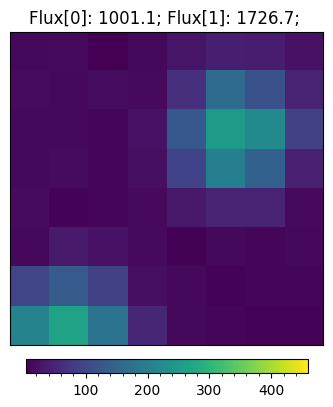

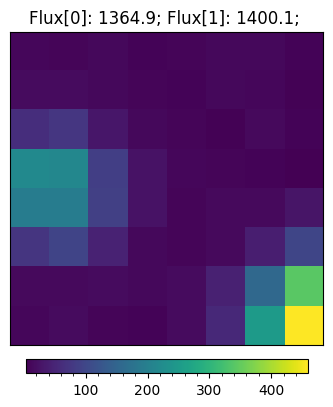

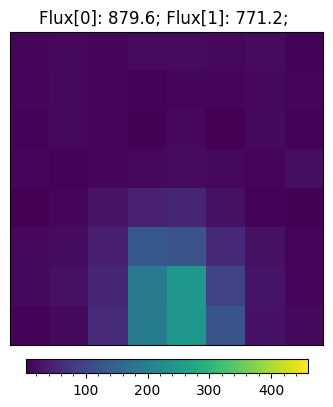

In [7]:
sim_out = image_simulator.generate(3, seed=7272)
img_min = sim_out["images"].min()
img_max = sim_out["images"].max()
for sub_img, flux in zip(sim_out["images"], sim_out["fluxes"]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(sub_img.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    if flux.shape[0] == 1:
        ax.set_title(f"Flux: {flux.item():.1f}")
    else:
        t = ""
        for i, f in enumerate(flux):
            t += f"Flux[{i}]: {f.item():.1f}; "
        ax.set_title(t)
    cb = fig.colorbar(im, ax=ax, 
                      location="bottom", shrink=0.6,
                      anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [28]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=4,
                                  lambda_=1.0,
                                  beta=0.5)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)

In [9]:
my_net = FourierMLP(data_shape=[2, 1], 
                    num_layers=4, 
                    hidden_ch=32).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [10]:
def encode_x_start(catalog):
    n_sources = catalog["counts"]  # (b, )
    n_sources = (n_sources.unsqueeze(-1) >= torch.arange(1, max_objects + 1, device=device)).unsqueeze(-1)  # (b, m, 1)
    x_start = (n_sources * 2 - 1).float()
    return x_start

In [11]:
def decode_x_start(output_x_start):
    n_sources = output_x_start[..., 0] > 0.0  # (b, m)
    return {
        "counts": n_sources.sum(dim=-1),
        "n_sources": n_sources.int(),
    }

In [12]:
def normalize_image(input_image):
    match image_normalize_strategy:
        case "none":
            output_image = input_image
        case "log":
            output_image = torch.log1p(input_image)
        case "linear_scale":
            output_image = input_image / 1000
        case _:
            raise NotImplementedError()
    return output_image

In [13]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    input_image = catalog["images"]  # (b, h, w)
    input_image = normalize_image(input_image)
    train_loss_args = {
        "model": my_net,
        "x_start": encode_x_start(catalog),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  5%|▌         | 509/10000 [00:09<02:57, 53.47it/s]

[500/10000] loss: 3.614e-02


 10%|█         | 1007/10000 [00:18<02:45, 54.38it/s]

[1000/10000] loss: 2.950e-02


 15%|█▌        | 1506/10000 [00:27<02:34, 55.00it/s]

[1500/10000] loss: 2.461e-02


 20%|██        | 2010/10000 [00:37<02:28, 53.98it/s]

[2000/10000] loss: 2.789e-02


 25%|██▌       | 2508/10000 [00:46<02:21, 52.95it/s]

[2500/10000] loss: 2.414e-02


 30%|███       | 3006/10000 [00:55<02:12, 52.85it/s]

[3000/10000] loss: 2.199e-02


 35%|███▌      | 3510/10000 [01:05<01:54, 56.44it/s]

[3500/10000] loss: 2.255e-02


 40%|████      | 4008/10000 [01:14<01:53, 52.87it/s]

[4000/10000] loss: 1.852e-02


 45%|████▌     | 4506/10000 [01:23<01:43, 52.98it/s]

[4500/10000] loss: 1.819e-02


 50%|█████     | 5005/10000 [01:32<01:31, 54.43it/s]

[5000/10000] loss: 2.194e-02


 55%|█████▌    | 5509/10000 [01:42<01:22, 54.25it/s]

[5500/10000] loss: 2.428e-02


 60%|██████    | 6007/10000 [01:51<01:14, 53.36it/s]

[6000/10000] loss: 1.746e-02


 65%|██████▌   | 6505/10000 [02:00<01:05, 53.64it/s]

[6500/10000] loss: 1.671e-02


 70%|███████   | 7009/10000 [02:10<00:55, 54.04it/s]

[7000/10000] loss: 2.017e-02


 75%|███████▌  | 7507/10000 [02:19<00:45, 54.96it/s]

[7500/10000] loss: 1.824e-02


 80%|████████  | 8005/10000 [02:28<00:37, 52.81it/s]

[8000/10000] loss: 1.595e-02


 85%|████████▌ | 8509/10000 [02:38<00:27, 53.68it/s]

[8500/10000] loss: 1.650e-02


 90%|█████████ | 9007/10000 [02:47<00:17, 55.49it/s]

[9000/10000] loss: 1.748e-02


 95%|█████████▌| 9505/10000 [02:56<00:09, 52.65it/s]

[9500/10000] loss: 1.702e-02


100%|██████████| 10000/10000 [03:05<00:00, 53.85it/s]

[10000/10000] loss: 1.702e-02


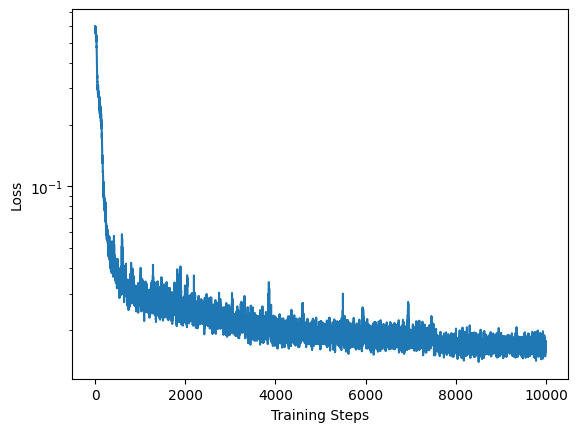

In [14]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [29]:
my_net.eval()
val_true_cat = []
val_est_cat = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(1000))):
        val_catalog = image_simulator.generate(batch_size=1024)
        input_image = normalize_image(val_catalog["images"])
        val_catalog = decode_x_start(encode_x_start(val_catalog))
        val_true_cat.append(move_data_to_device(val_catalog, "cpu"))
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1024, max_objects, 1),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_cat.append(move_data_to_device(decode_x_start(sample), "cpu"))

100%|██████████| 1000/1000 [00:14<00:00, 69.37it/s]


In [30]:
diffusion_pred_ns = []
diffusion_true_ns = []
for ec, tc in zip(val_est_cat, val_true_cat, strict=True):
    diffusion_pred_ns.append(ec["n_sources"])
    diffusion_true_ns.append(tc["n_sources"])
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)

In [31]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [32]:
def plot_cm(d_pred_bin_index, d_true_bin_index, bin_num, bin_labels, axis_label):
    d_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(d_cm.shape[0]):
        for ci in range(d_cm.shape[1]):
            d_cm[ri, ci] = ((d_pred_bin_index == ri) & (d_true_bin_index == ci)).sum()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion")
    fig.show()

    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
    #             annot=True,
    #             fmt=".2f", cmap="Greens", cbar=False,
    #             xticklabels=bin_labels,
    #             yticklabels=bin_labels,
    #             ax=ax)
    # ax.set_xlabel(f"True {axis_label}")
    # ax.set_ylabel(f"Pred {axis_label}")
    # ax.set_title("Diffusion (CM in Percent)")
    # fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
                annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion (Asymmetry Factor)")
    fig.show()

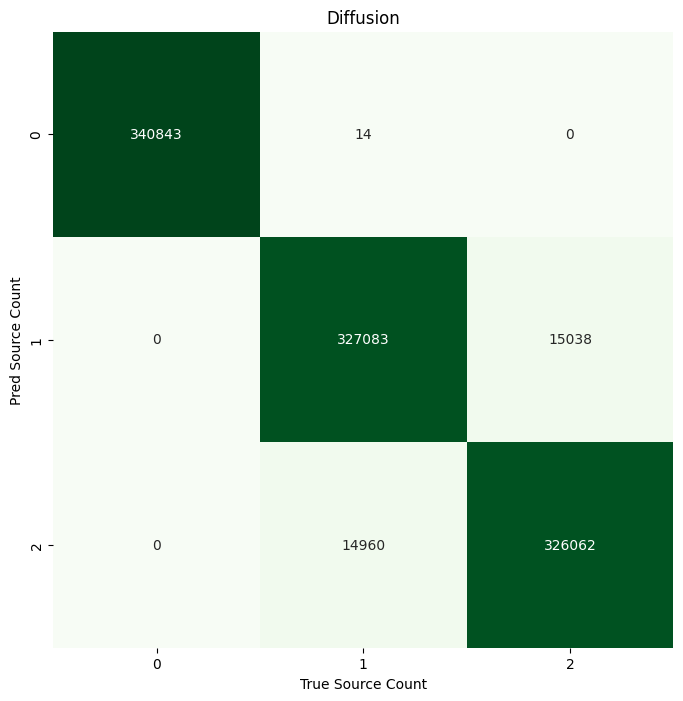

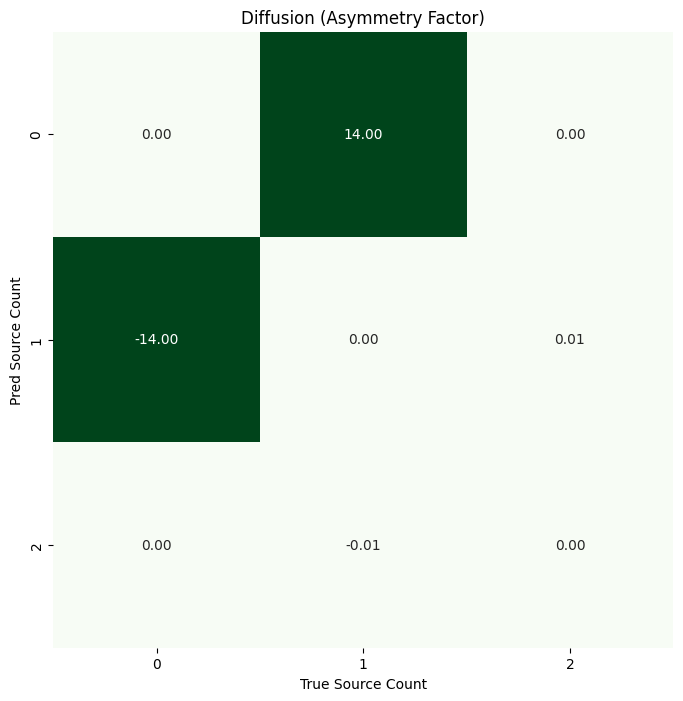

In [33]:
plot_cm(diffusion_pred_ns.sum(dim=-1), diffusion_true_ns.sum(dim=-1), 
        bin_num=3, bin_labels=list(range(3)), axis_label="Source Count")